<h1>0. 지하철 이용자 수 예측 모델</h1>

아마 이 내용을 직접 사용하진 않을것이지만, ARIMA모델을 만드는 과정에 대한 예시로 작성해두었다.<br>
ARIMA는 대충 이렇게 굴러가는거구나~ 하고 보면 좋을것같다.

In [ ]:
# ARIMA 최적화를 위한 모듈(모듈 내 auto_arima함수가 p, d, q 값을 찾아줌)
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 31.7 MB/s 
     |████████████████████████████████| 9.8 MB 57.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# 훈련세트와 테스트를 나눠주는 모듈
from sklearn.model_selection import train_test_split
# 선형회귀를 위해 필요한 모듈
from sklearn.linear_model import LinearRegression
# 주어진 특성들을 이용해 새로운 특성을 만들어주는 모듈
from sklearn.preprocessing import PolynomialFeatures
# 표준화를 하기 위한 모듈
from sklearn.preprocessing import StandardScaler

In [ ]:
# 시차를 만들어 주기위한 timedelta와 datetime
from datetime import datetime, timedelta

In [ ]:
# 일일 지하철 이용자 수 데이터
metro_data = pd.read_csv("/content/drive/MyDrive/data/MLR/일간지하철승차량.csv")
# 인덱스 초기화
metro_data = metro_data.reset_index(drop=True)
# '사용일자' col명 변경(기준일이 직관성이 좋음)
metro_data.rename(columns={"사용일자": "기준일"}, inplace=True)
# '기준일' col의 data type을 datetime로 바꿔줌.
metro_data = metro_data.astype({'기준일': 'datetime64'})
metro_data

,기준일,일별이용자수
0,2018-01-01,3520929
1,2018-01-02,7505016
2,2018-01-03,7681469
3,2018-01-04,7705415
4,2018-01-05,8134256
...,...,...
1395,2021-10-27,6788314
1396,2021-10-28,6763319
1397,2021-10-29,6975784
1398,2021-10-30,5076792


In [ ]:
# 설날, 추석에 대한 데이터를 수정(명절은 출퇴근 인구가 서울밖으로 이동했다고 가정 : 유동인구는 변함없다)
# 해당 날짜 기준 일주일 전과 후의 평균을 사용함
# 2018년 설날
metro_data.loc[metro_data["기준일"]=="2018-01-15", ["일별이용자수"]] = 8028572
metro_data.loc[metro_data["기준일"]=="2018-01-16", ["일별이용자수"]] = 8369734
metro_data.loc[metro_data["기준일"]=="2018-01-17", ["일별이용자수"]] = 6397631
metro_data.loc[metro_data["기준일"]=="2018-01-18", ["일별이용자수"]] = 4558136
# 2018년 추석
metro_data.loc[metro_data["기준일"]=="2018-09-23", ["일별이용자수"]] = 4745370
metro_data.loc[metro_data["기준일"]=="2018-09-24", ["일별이용자수"]] = 8216019
metro_data.loc[metro_data["기준일"]=="2018-09-25", ["일별이용자수"]] = 8463516
metro_data.loc[metro_data["기준일"]=="2018-09-26", ["일별이용자수"]] = 8432796
# 2019년 설날
metro_data.loc[metro_data["기준일"]=="2019-02-02", ["일별이용자수"]] = 6176507
metro_data.loc[metro_data["기준일"]=="2019-02-03", ["일별이용자수"]] = 4498127
metro_data.loc[metro_data["기준일"]=="2019-02-04", ["일별이용자수"]] = 7893656
metro_data.loc[metro_data["기준일"]=="2019-02-05", ["일별이용자수"]] = 8016545
metro_data.loc[metro_data["기준일"]=="2019-02-06", ["일별이용자수"]] = 8101662
# 2019년 추석
metro_data.loc[metro_data["기준일"]=="2019-09-12", ["일별이용자수"]] = 8359307
metro_data.loc[metro_data["기준일"]=="2019-09-13", ["일별이용자수"]] = 8831129
metro_data.loc[metro_data["기준일"]=="2019-09-14", ["일별이용자수"]] = 5702210
metro_data.loc[metro_data["기준일"]=="2019-09-15", ["일별이용자수"]] = 4567029
# 2020년 설날
metro_data.loc[metro_data["기준일"]=="2020-01-24", ["일별이용자수"]] = 8067047
metro_data.loc[metro_data["기준일"]=="2020-01-25", ["일별이용자수"]] = 5655860
metro_data.loc[metro_data["기준일"]=="2020-01-26", ["일별이용자수"]] = 4023238
metro_data.loc[metro_data["기준일"]=="2020-01-27", ["일별이용자수"]] = 7515497
# 2020년 추석
metro_data.loc[metro_data["기준일"]=="2020-09-30", ["일별이용자수"]] = 6298965
metro_data.loc[metro_data["기준일"]=="2020-10-01", ["일별이용자수"]] = 6431641
metro_data.loc[metro_data["기준일"]=="2020-10-02", ["일별이용자수"]] = 6664781
metro_data.loc[metro_data["기준일"]=="2020-10-03", ["일별이용자수"]] = 4151272
# 2021년 설날
metro_data.loc[metro_data["기준일"]=="2021-02-11", ["일별이용자수"]] = 6157047
metro_data.loc[metro_data["기준일"]=="2021-02-12", ["일별이용자수"]] = 6399803
metro_data.loc[metro_data["기준일"]=="2021-02-13", ["일별이용자수"]] = 4151651
metro_data.loc[metro_data["기준일"]=="2021-02-14", ["일별이용자수"]] = 2920894
# 2021년 추석
metro_data.loc[metro_data["기준일"]=="2021-09-19", ["일별이용자수"]] = 3170096
metro_data.loc[metro_data["기준일"]=="2021-09-20", ["일별이용자수"]] = 6275797
metro_data.loc[metro_data["기준일"]=="2021-09-21", ["일별이용자수"]] = 6313398
metro_data.loc[metro_data["기준일"]=="2021-09-22", ["일별이용자수"]] = 6265015

In [ ]:
# 학습시킬 데이터 기간 조절(이번엔 코로나 이후의 기간을 가지고 학습해봄)
metro_data = metro_data[metro_data['기준일']>'2020-01-19']

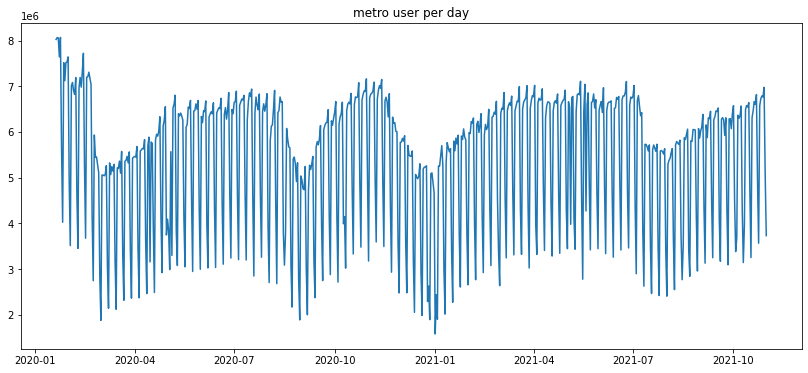

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = plt.subplot(1,1,1)

plt.title("metro user per day")
ax.plot(metro_data['기준일'], metro_data['일별이용자수'])

plt.show()

In [ ]:
# 시계열 데이터 생성
timeSeries = metro_data.loc[:, ["기준일", "일별이용자수"]]
timeSeries.index = timeSeries.기준일
ts = timeSeries.drop("기준일", axis=1)

In [ ]:
ts

,일별이용자수
기준일,
2020-01-20,8023369
2020-01-21,8063435
2020-01-22,8058478
2020-01-23,7641489
2020-01-24,8067047
...,...
2021-10-27,6788314
2021-10-28,6763319
2021-10-29,6975784


[시계열 분해](https://leedakyeong.tistory.com/entry/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%ED%95%B4%EB%9E%80Time-Series-Decomposition-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%B6%84%EC%84%9D%EC%9D%B4%EB%9E%80-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%80-%EC%B6%94%EC%84%B8Trend-%EC%88%9C%ED%99%98Cycle-%EA%B3%84%EC%A0%88%EC%84%B1Seasonal-%EB%B6%88%EA%B7%9C%EC%B9%99-%EC%9A%94%EC%86%8CRandom-Residual)
를 사용해 지하철이용자수 데이터를 확인함

In [ ]:
# 계절성, 추세, 편차를 확인하기 위한 모듈
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

<Figure size 432x288 with 0 Axes>

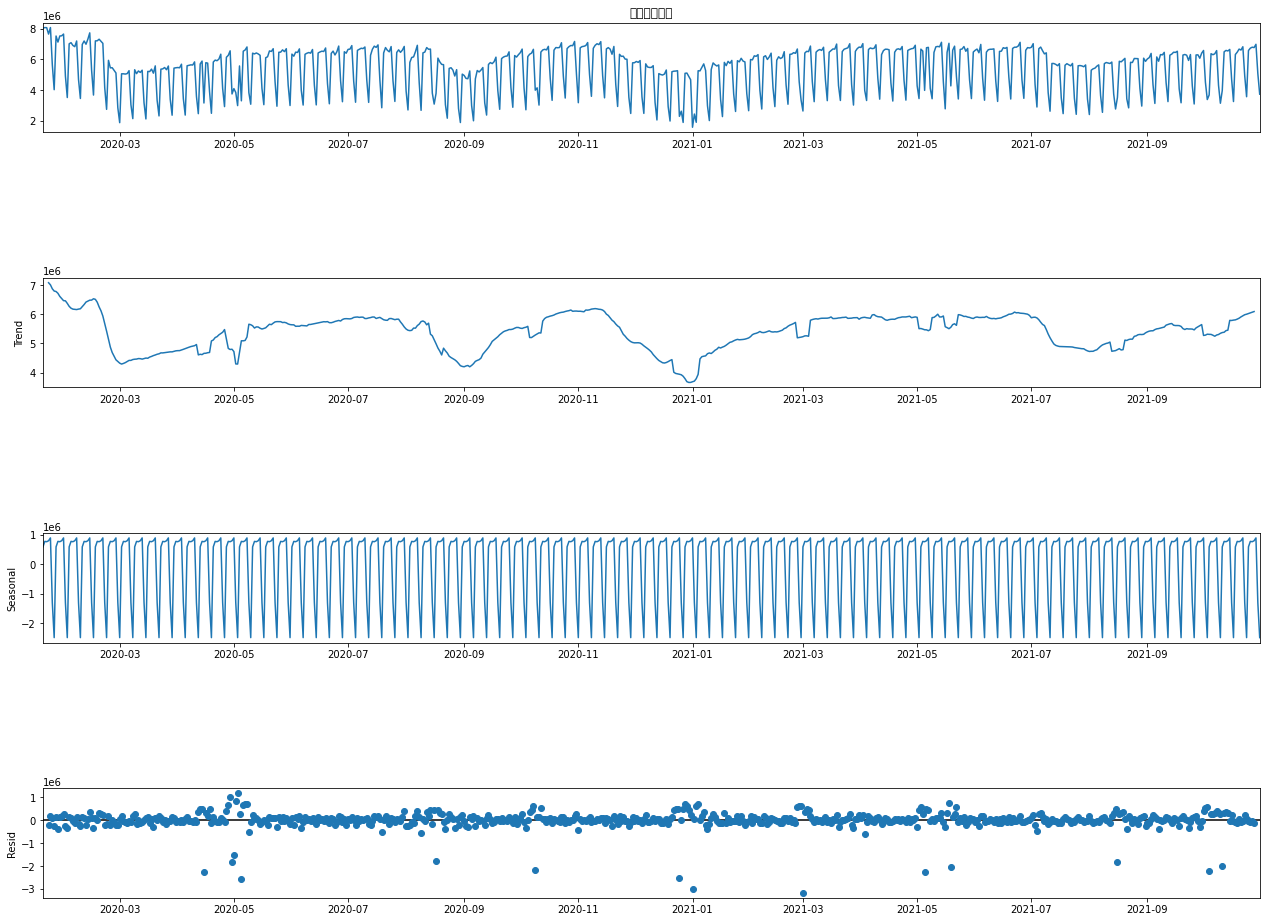

In [ ]:
# model='additive' : 합분해(cf. multipulicate : 곱분해) | freq=7 : 계절주기를 7(일주일로) 보통 일간 데이터는 7부터 사용해 확인.
result = seasonal_decompose(ts['일별이용자수'], model='additive', period=7)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

[ARIMA](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80?category=854707) 모델에 사용하는 p, d, q값은 [하이퍼파라미터](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-13-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0Parameter%EC%99%80-%ED%95%98%EC%9D%B4%ED%8D%BC-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0Hyper-parameter)이다.<br>
우리가 직접 판단해서 선택해도 되지만(보통 ACF그래프와 PACF그래프를 통해 구한다.)<br>이번에는 auto_arima의 힘을 빌려 p, d, q을 설정하겠다.(이 값이 무조건 최선인 것은 아니다.)<br>
해당 함수는 각 p, d, q에 대한 ARIMA모델을 시뮬레이션 하여 [AIC](https://m.blog.naver.com/euleekwon/221465294530)값을 제공해준다.<br>
해당 값이 가장 낮은 모델이 적합한 모델이라 할 수 있겠다.

In [ ]:
from pmdarima import auto_arima


# 계절성 주기가 7이므로 최대 탐색값을 7로 설정했음(이는 정해진 규칙이 아님에 주의.)
stepwise_fit = auto_arima(ts, trace=True, suppress_warnings=True, max_p=7, max_q=7, max_d=7)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20151.758, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20319.143, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20218.710, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20152.825, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22081.177, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=20150.191, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=20149.819, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=20161.525, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20164.878, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=20130.833, Time=0.71 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=20101.931, Time=0.72 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=19984.309, Time=1.69 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=20075.812, Time=1.17 sec
 ARIMA(3,0,4)(0,0,0)[0] i

In [ ]:
# 훈련세트와 검증세트를 나눈다. 시계열 데이터이므로 연속된 세트를 이용한다.
# 왜 연속된 값을 사용하는지 이해가 안간다면 AR모델과 MA모델을 다시 검색해볼 것.
print(ts.shape)
# 편의상 30개의 샘플을 검증세트로 사용하였지만, 통상적으론 int(len(ts) * 0.2) 같이 비율을 정하여 나누는 편이다.
train = ts.iloc[:-30]
test = ts.iloc[-30:]
print(train.shape, test.shape)

(651, 1)
(621, 1) (30, 1)


In [ ]:
# ARIMA모델을 학습하는 함수
from statsmodels.tsa.arima.model import ARIMA
# 이 모듈을 통해 자잘한 경고 메시지를 무시할 수 있다. 한번 없이 해보는것도 좋은 경험(소중함을 느낄 수 있음)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model = ARIMA(train['일별이용자수'], order = (7,0,5))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 일별이용자수   No. Observations:                  621
Model:                 ARIMA(7, 0, 5)   Log Likelihood               -9087.169
Date:                Sun, 28 Nov 2021   AIC                          18202.339
Time:                        09:39:01   BIC                          18264.378
Sample:                    01-20-2020   HQIC                         18226.452
                         - 10-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.407e+06   5.38e-09   1.01e+15      0.000    5.41e+06    5.41e+06
ar.L1          0.1204      0.032      3.717      0.000       0.057       0.184
ar.L2         -0.1442      0.033     -4.365      0.000      -0.209      -0.079
ar.L3          0.0007      0.036      0.018      0.986      -0.071       0.072
ar.L4         -0.0074      0.036     -0.203      0.839      -0.078       0.064
ar.L5         -0.1382      0.032     -4.378      0.000      -0.200      -0.076
ar.L6          0.1160      0.032      3.647      0.000       0.054       0.178
ar.L7          0.7785      0.024     31.916      0.000       0.731       0.826
ma.L1          0.0650      0.038      1.694      0.090      -0.010       0.140
ma.L2          0.4275      0.040     10.676      0.000       0.349       0.506
ma.L3          0.2590      0.047      5.486      0.000       0.166       0.352
ma.L4          0.2953      0.039      7.619      0.000       0.219       0.371
ma.L5          0.4680      0.038     12.245      0.000       0.393       0.543
sigma2      3.145e+11   1.03e-13   3.06e+24      0.000    3.15e+11    3.15e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2858.33
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -1.35
Prob(H) (two-sided):                  0.01   Kurtosis:                        13.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+40. Standard errors may be unstable.
"""

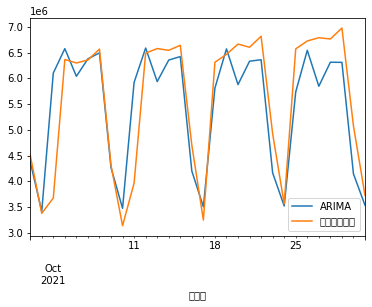

In [ ]:
# 검증세트에 대한 예측값을 보여줌
start = len(train)
end = len(ts) - 1
pred = model_fit.predict(start=start, end=end, typ='levels').rename("ARIMA")
pred.plot(legend=True)
# 검증세트에 대한 실측값을 보여줌
test['일별이용자수'].plot(legend=True)

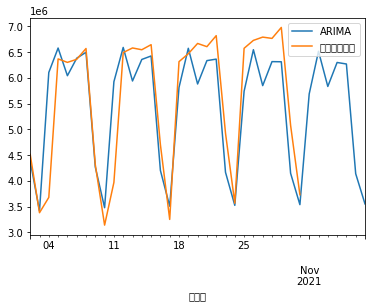

In [ ]:
# 심심하니 11월 첫주에 대한 예측값도 구해봄.
# ARIMA모델같은 예측형 모델은 먼 미래를 예측할 수록 정확도가 급격히 떨어짐(이전의 예측값을 예측에 사용하기 때문 = 오차 2배 이벤트)
pred = model_fit.predict(start='2021-10-02', end='2021-11-7', typ='levels').rename("ARIMA")
pred.plot(legend=True)
test['일별이용자수'].plot(legend=True)

<h1>1.상관계수 확인</h1>
이제 우리가 필요한 작업을 시작해보자.<br>
두 시계열 데이터의 상관관계를 살펴보기 위해서는 두 시계열이 stationary해야한다.<br>
non-stationary한 데이터는 차분이나 log를 이용하거나 시계열 분해를 이용해 stationary하게 만들 수 있다.<br>
우리는 먼저 지하철 이용자수 데이터와 코로나 신규확진자 데이터에서 계절성, 추세 요소를 제거 한 후 그 둘을 비교해보겠다.

<h2>1-1.지하철 이용자 수</h2>

In [ ]:
# 일일 지하철 이용자 수 데이터
metro_data = pd.read_csv("/content/drive/MyDrive/data/MLR/일간지하철승차량.csv")
# 인덱스 초기화
metro_data = metro_data.reset_index(drop=True)
# '사용일자' col명 변경(기준일이 직관성이 좋음)
metro_data.rename(columns={"사용일자": "기준일"}, inplace=True)
# '기준일' col의 data type을 datetime로 바꿔줌.
metro_data = metro_data.astype({'기준일': 'datetime64'})
metro_data

,기준일,일별이용자수
0,2018-01-01,3520929
1,2018-01-02,7505016
2,2018-01-03,7681469
3,2018-01-04,7705415
4,2018-01-05,8134256
...,...,...
1395,2021-10-27,6788314
1396,2021-10-28,6763319
1397,2021-10-29,6975784
1398,2021-10-30,5076792


In [ ]:
# 설날, 추석에 대한 데이터를 수정(명절은 출퇴근 인구가 서울밖으로 이동했다고 가정 : 유동인구는 변함없다)
# 2018년 설날
metro_data.loc[metro_data["기준일"]=="2018-01-15", ["일별이용자수"]] = 8028572
metro_data.loc[metro_data["기준일"]=="2018-01-16", ["일별이용자수"]] = 8369734
metro_data.loc[metro_data["기준일"]=="2018-01-17", ["일별이용자수"]] = 6397631
metro_data.loc[metro_data["기준일"]=="2018-01-18", ["일별이용자수"]] = 4558136
# 2018년 추석
metro_data.loc[metro_data["기준일"]=="2018-09-23", ["일별이용자수"]] = 4745370
metro_data.loc[metro_data["기준일"]=="2018-09-24", ["일별이용자수"]] = 8216019
metro_data.loc[metro_data["기준일"]=="2018-09-25", ["일별이용자수"]] = 8463516
metro_data.loc[metro_data["기준일"]=="2018-09-26", ["일별이용자수"]] = 8432796
# 2019년 설날
metro_data.loc[metro_data["기준일"]=="2019-02-02", ["일별이용자수"]] = 6176507
metro_data.loc[metro_data["기준일"]=="2019-02-03", ["일별이용자수"]] = 4498127
metro_data.loc[metro_data["기준일"]=="2019-02-04", ["일별이용자수"]] = 7893656
metro_data.loc[metro_data["기준일"]=="2019-02-05", ["일별이용자수"]] = 8016545
metro_data.loc[metro_data["기준일"]=="2019-02-06", ["일별이용자수"]] = 8101662
# 2019년 추석
metro_data.loc[metro_data["기준일"]=="2019-09-12", ["일별이용자수"]] = 8359307
metro_data.loc[metro_data["기준일"]=="2019-09-13", ["일별이용자수"]] = 8831129
metro_data.loc[metro_data["기준일"]=="2019-09-14", ["일별이용자수"]] = 5702210
metro_data.loc[metro_data["기준일"]=="2019-09-15", ["일별이용자수"]] = 4567029
# 2020년 설날
metro_data.loc[metro_data["기준일"]=="2020-01-24", ["일별이용자수"]] = 8067047
metro_data.loc[metro_data["기준일"]=="2020-01-25", ["일별이용자수"]] = 5655860
metro_data.loc[metro_data["기준일"]=="2020-01-26", ["일별이용자수"]] = 4023238
metro_data.loc[metro_data["기준일"]=="2020-01-27", ["일별이용자수"]] = 7515497
# 2020년 추석
metro_data.loc[metro_data["기준일"]=="2020-09-30", ["일별이용자수"]] = 6298965
metro_data.loc[metro_data["기준일"]=="2020-10-01", ["일별이용자수"]] = 6431641
metro_data.loc[metro_data["기준일"]=="2020-10-02", ["일별이용자수"]] = 6664781
metro_data.loc[metro_data["기준일"]=="2020-10-03", ["일별이용자수"]] = 4151272
# 2021년 설날
metro_data.loc[metro_data["기준일"]=="2021-02-11", ["일별이용자수"]] = 6157047
metro_data.loc[metro_data["기준일"]=="2021-02-12", ["일별이용자수"]] = 6399803
metro_data.loc[metro_data["기준일"]=="2021-02-13", ["일별이용자수"]] = 4151651
metro_data.loc[metro_data["기준일"]=="2021-02-14", ["일별이용자수"]] = 2920894
# 2021년 추석
metro_data.loc[metro_data["기준일"]=="2021-09-19", ["일별이용자수"]] = 3170096
metro_data.loc[metro_data["기준일"]=="2021-09-20", ["일별이용자수"]] = 6275797
metro_data.loc[metro_data["기준일"]=="2021-09-21", ["일별이용자수"]] = 6313398
metro_data.loc[metro_data["기준일"]=="2021-09-22", ["일별이용자수"]] = 6265015

In [ ]:
# 비교해 볼 데이터 기간 조절(이번엔 델타 변이 유행시기 즈음 부터 해보자.)
metro_data = metro_data[metro_data['기준일']>'2021-07-04']

In [ ]:
# 시계열 데이터 생성
timeSeries = metro_data.loc[:, ["기준일", "일별이용자수"]]
timeSeries.index = timeSeries.기준일
metro_ts = timeSeries.drop("기준일", axis=1)

In [ ]:
metro_ts

,일별이용자수
기준일,
2021-07-05,6688907
2021-07-06,6795107
2021-07-07,6560203
2021-07-08,6353176
2021-07-09,6421539
...,...
2021-10-27,6788314
2021-10-28,6763319
2021-10-29,6975784


<Figure size 432x288 with 0 Axes>

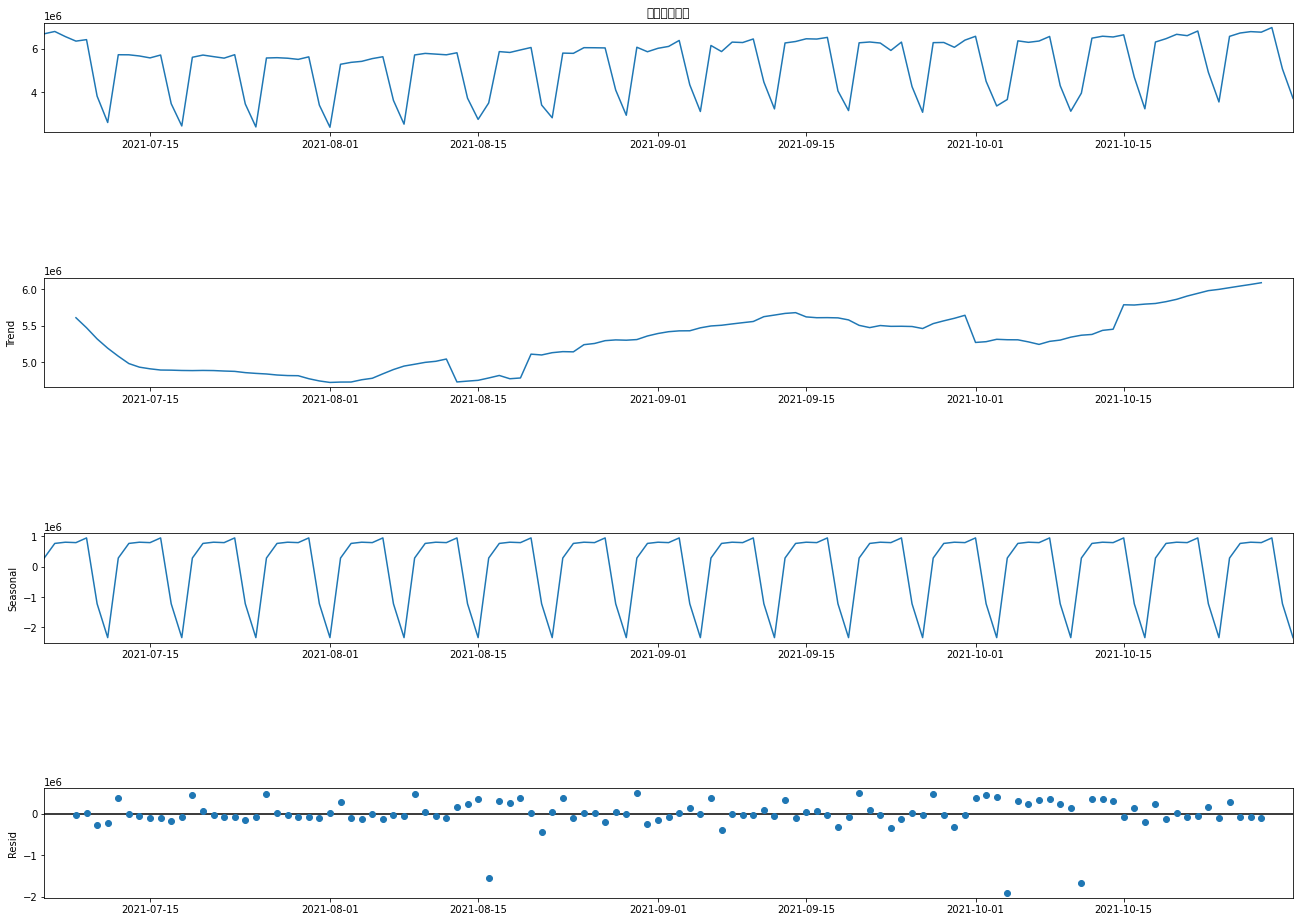

In [ ]:
# model='additive' : 합분해 | period=7 : 계절주기를 7(일주일로) 보통 일간 데이터는 7부터 사용해 확인.
result1 = seasonal_decompose(metro_ts['일별이용자수'], model='additive', period=7)

fig = plt.figure()
fig = result1.plot()
fig.set_size_inches(20, 15)

In [ ]:
# 추세(trend)와 계절(seasonal) 성분을 제거해줌
# timeseries = seasonal + trend + residue
metro_nonseason = result1.resid.dropna()

In [ ]:
metro_nonseason = metro_nonseason.diff().dropna()

앞서 분해한 residue가 stationary한지 살펴보자.<br>
우리는 [ADF검정과 KPSS검정](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)을 이용할 것이다.

In [ ]:
# ADF검정
from statsmodels.tsa.stattools import adfuller

In [ ]:
# ADF검정을 통해 정상성을 확인해봄
# 귀무가설 : stationary 하지 않음
result = adfuller(metro_nonseason)
print(result[1])

3.0518898312973597e-12


In [ ]:
# KPSS검정
from statsmodels.tsa.stattools import kpss

In [ ]:
# KPSS검정을 통해 정상성을 확인해봄.
# 귀무가설 : stationary 함
result = kpss(metro_nonseason)
print(result[1])

0.1


두 테스트 결과. metro_nonseason이 stationary함을 확인하였다.<br>
두 테스트에 대한 모든 케이스는 다음과 같다.<br>


*   ADF : stationary | KPSS : stationary => stationary함
*   ADF : non-stationary | KPSS : non-stationary => non-stationary함
*   ADF : stationary | KPSS : non-stationary => difference stationary함. 차분을 통해 station하게 만들어야 함
*   ADF : non-stationary | KPSS : stationary => trend stationary함. trend를 제거하여 station하게 만들어야 함



In [ ]:
metro_nonseason

기준일
2021-07-09     51004.630777
2021-07-10   -276718.607143
2021-07-11     30171.348214
2021-07-12    604109.892857
2021-07-13   -382023.107143
                  ...      
2021-10-24   -267025.366071
2021-10-25    372246.750000
2021-10-26   -349040.964286
2021-10-27      2029.455357
2021-10-28    -35094.470063
Name: resid, Length: 112, dtype: float64

<h2>1-2. 코로나 신규 확진자수</h2>

In [ ]:
# 서울시 일일 신규 확진자수 데이터
confirmed_data = pd.read_csv("/content/drive/MyDrive/data/MLR/서울시_신규확진자.csv", encoding='euc-kr')
# '기준일' col의 data type을 datetime로 바꿔줌.
confirmed_data = confirmed_data.astype({'기준일': 'datetime64'})
confirmed_data

,기준일,신규확진자
0,2020-01-20,0
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
666,2021-11-16,846
667,2021-11-17,1436
668,2021-11-18,1429
669,2021-11-19,1401


In [ ]:
# 확진자수의 양상(매주 월화의 수가 적음)을 통해 지하철(매주 토일값이 적음) 이용 2일 혹은 9일 후 정도가 판단하기 좋을 것이라 생각했다.
# 이번엔 2일 후를 기준으로 상관관계를 확인해 보겠다.
# 비교해 볼 데이터 기간 조절(이번엔 델타 변이 유행시기 즈음 부터 해보자.)
confirmed_data = confirmed_data[confirmed_data['기준일']>'2021-07-07']
# 지하철 이용자 수 데이터와 길이를 맞춰줌
confirmed_data = confirmed_data[confirmed_data['기준일']<'2021-11-03']

In [ ]:
# 시계열 데이터 생성
timeSeries = confirmed_data.loc[:, ["기준일", "신규확진자"]]
timeSeries.index = timeSeries.기준일
confirmed_ts = timeSeries.drop("기준일", axis=1)

In [ ]:
confirmed_ts

,신규확진자
기준일,
2021-07-08,550
2021-07-09,503
2021-07-10,509
2021-07-11,509
2021-07-12,403
...,...
2021-10-29,770
2021-10-30,706
2021-10-31,760


<Figure size 432x288 with 0 Axes>

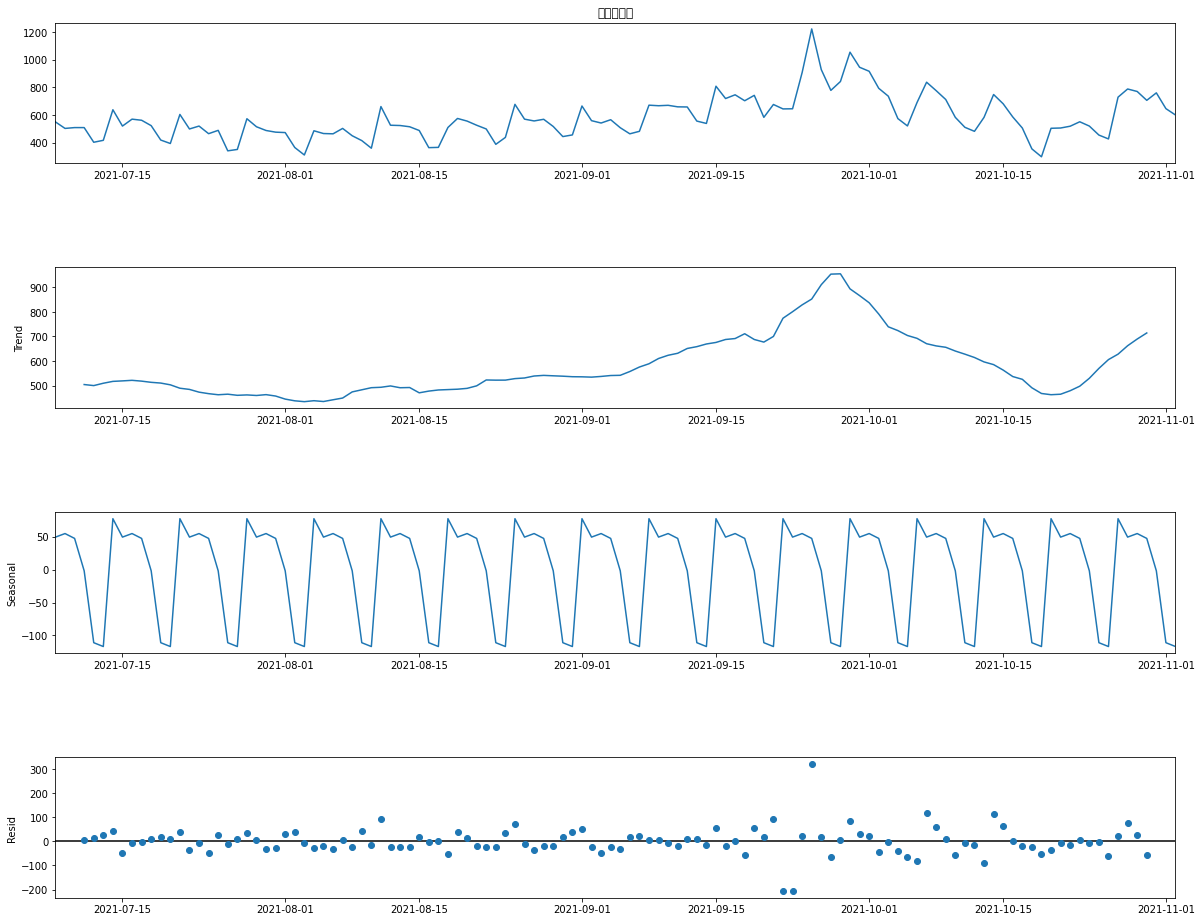

In [ ]:
result2 = seasonal_decompose(confirmed_ts['신규확진자'], model='additive', period=7)

fig = plt.figure()
fig = result2.plot()
fig.set_size_inches(20, 15)

In [ ]:
confirmed_nonseason = result2.resid.dropna()

In [ ]:
confirmed_nonseason

기준일
2021-07-11     6.576531
2021-07-12    14.112245
2021-07-13    24.362245
2021-07-14    43.487245
2021-07-15   -48.521684
                ...    
2021-10-26   -61.923469
2021-10-27    23.630102
2021-10-28    76.335459
2021-10-29    25.656888
2021-10-30   -55.673469
Name: resid, Length: 112, dtype: float64

In [ ]:
# ADF검정을 통해 정상성을 확인해봄
# 귀무가설 : stationary 하지 않음
result = adfuller(confirmed_nonseason)
print(result[1])

2.0790339943788992e-11


In [ ]:
# KPSS검정을 통해 정상성을 확인해봄.
# 귀무가설 : stationary 함
result = kpss(confirmed_nonseason)
print(result[1])

0.1


In [ ]:
# 두 요인을 x변수 y변수에 저장
x = metro_nonseason.to_numpy()
y = confirmed_nonseason.to_numpy()

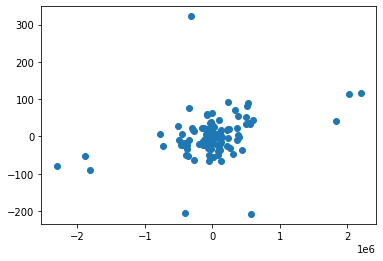

In [ ]:
# 산점도 확인
plt.plot(x, y, 'o')
plt.show()

In [ ]:
import scipy.stats as stats

In [ ]:
# 상관계수와 p-value를 확인하여 상관계수를 구하고 그 자체가 유의미 한지 확인
# 첫번째 값은 상관계수, 두번째 값은 p-value를 뜻한다.
stats.pearsonr(x, y)

(0.3433586213486486, 0.00021027617003411753)

보통 상관계수가 0.3~0.7 사이면 뚜렷한 양적 선형관계로,<br>
0.7에서 1.0사이면 강한 양적 선형관계로 간주한다.<br>
확인결과 두 변수 사이엔(0.3에 가깝긴하지만) 뚜렷한 선형관계가 관측되었다.<br>
그러나 산점도의 모양으로 보아 좋은 성과를 얻기는 힘들어보인다.

In [ ]:
# 현재 x, y 의 상태는 [[,]]의 2차원 리스트 구조이다. 선형회귀를 위해 1차원 리스트로 reshape해주자
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)

# 범위 학습
scaler = StandardScaler()
scaler.fit(x_train)

# 훈련 세트 변환
trans_x_train = scaler.transform(x_train)

# 검증 세트 변환
trans_x_test = scaler.transform(x_test)

line_fitter = LinearRegression()
line_fitter.fit(trans_x_train, y_train)

LinearRegression()

In [ ]:
print(line_fitter.coef_, line_fitter.intercept_)

[[21.49740167]] [-0.53663151]


In [ ]:
line_fitter.score(trans_x_train, y_train)

0.12020630712006197

In [ ]:
line_fitter.score(trans_x_test, y_test)

0.05039337398061716

단순 선형회귀결과 기울기값이 양수가 나왔지만(이용자수와 확진자 수가 정비례), 모델의 적합도가 너무 낮아 신뢰도가 의심스럽다.<br>
아마 더욱 복잡한 모델을 사용하면(ex. LSTM) 결과가 개선되리라 예상한다.

<h1>2. 다른 방식의 변환 시도</h1>

앞선 과정에서는 seasonal_decompose를 통해 seasonal 성분과 trend 성분을 모두 제거해 주어 해당 데이터를 stationary하게 만들었다<br>
이번엔 지하철 데이터가 매우 강한 계절성을 띈다는 점을 이용해 seasonal differencing을 이용해보겠다.

<h2>지하철 이용자수</h2>

In [ ]:
# 일일 지하철 이용자 수 데이터
metro_data = pd.read_csv("/content/drive/MyDrive/data/MLR/일간지하철승차량.csv")
# 인덱스 초기화
metro_data = metro_data.reset_index(drop=True)
# '사용일자' col명 변경(기준일이 직관성이 좋음)
metro_data.rename(columns={"사용일자": "기준일"}, inplace=True)
# '기준일' col의 data type을 datetime로 바꿔줌.
metro_data = metro_data.astype({'기준일': 'datetime64'})
metro_data

,기준일,일별이용자수
0,2018-01-01,3520929
1,2018-01-02,7505016
2,2018-01-03,7681469
3,2018-01-04,7705415
4,2018-01-05,8134256
...,...,...
1395,2021-10-27,6788314
1396,2021-10-28,6763319
1397,2021-10-29,6975784
1398,2021-10-30,5076792


In [ ]:
# 설날, 추석에 대한 데이터를 수정(명절은 출퇴근 인구가 서울밖으로 이동했다고 가정 : 유동인구는 변함없다)
# 2018년 설날
metro_data.loc[metro_data["기준일"]=="2018-01-15", ["일별이용자수"]] = 8028572
metro_data.loc[metro_data["기준일"]=="2018-01-16", ["일별이용자수"]] = 8369734
metro_data.loc[metro_data["기준일"]=="2018-01-17", ["일별이용자수"]] = 6397631
metro_data.loc[metro_data["기준일"]=="2018-01-18", ["일별이용자수"]] = 4558136
# 2018년 추석
metro_data.loc[metro_data["기준일"]=="2018-09-23", ["일별이용자수"]] = 4745370
metro_data.loc[metro_data["기준일"]=="2018-09-24", ["일별이용자수"]] = 8216019
metro_data.loc[metro_data["기준일"]=="2018-09-25", ["일별이용자수"]] = 8463516
metro_data.loc[metro_data["기준일"]=="2018-09-26", ["일별이용자수"]] = 8432796
# 2019년 설날
metro_data.loc[metro_data["기준일"]=="2019-02-02", ["일별이용자수"]] = 6176507
metro_data.loc[metro_data["기준일"]=="2019-02-03", ["일별이용자수"]] = 4498127
metro_data.loc[metro_data["기준일"]=="2019-02-04", ["일별이용자수"]] = 7893656
metro_data.loc[metro_data["기준일"]=="2019-02-05", ["일별이용자수"]] = 8016545
metro_data.loc[metro_data["기준일"]=="2019-02-06", ["일별이용자수"]] = 8101662
# 2019년 추석
metro_data.loc[metro_data["기준일"]=="2019-09-12", ["일별이용자수"]] = 8359307
metro_data.loc[metro_data["기준일"]=="2019-09-13", ["일별이용자수"]] = 8831129
metro_data.loc[metro_data["기준일"]=="2019-09-14", ["일별이용자수"]] = 5702210
metro_data.loc[metro_data["기준일"]=="2019-09-15", ["일별이용자수"]] = 4567029
# 2020년 설날
metro_data.loc[metro_data["기준일"]=="2020-01-24", ["일별이용자수"]] = 8067047
metro_data.loc[metro_data["기준일"]=="2020-01-25", ["일별이용자수"]] = 5655860
metro_data.loc[metro_data["기준일"]=="2020-01-26", ["일별이용자수"]] = 4023238
metro_data.loc[metro_data["기준일"]=="2020-01-27", ["일별이용자수"]] = 7515497
# 2020년 추석
metro_data.loc[metro_data["기준일"]=="2020-09-30", ["일별이용자수"]] = 6298965
metro_data.loc[metro_data["기준일"]=="2020-10-01", ["일별이용자수"]] = 6431641
metro_data.loc[metro_data["기준일"]=="2020-10-02", ["일별이용자수"]] = 6664781
metro_data.loc[metro_data["기준일"]=="2020-10-03", ["일별이용자수"]] = 4151272
# 2021년 설날
metro_data.loc[metro_data["기준일"]=="2021-02-11", ["일별이용자수"]] = 6157047
metro_data.loc[metro_data["기준일"]=="2021-02-12", ["일별이용자수"]] = 6399803
metro_data.loc[metro_data["기준일"]=="2021-02-13", ["일별이용자수"]] = 4151651
metro_data.loc[metro_data["기준일"]=="2021-02-14", ["일별이용자수"]] = 2920894
# 2021년 추석
metro_data.loc[metro_data["기준일"]=="2021-09-19", ["일별이용자수"]] = 3170096
metro_data.loc[metro_data["기준일"]=="2021-09-20", ["일별이용자수"]] = 6275797
metro_data.loc[metro_data["기준일"]=="2021-09-21", ["일별이용자수"]] = 6313398
metro_data.loc[metro_data["기준일"]=="2021-09-22", ["일별이용자수"]] = 6265015

In [ ]:
# 비교해 볼 데이터 기간 조절(이번엔 델타 변이 유행시기 즈음 부터 해보자.)
metro_data = metro_data[metro_data['기준일']>'2021-07-04']

In [ ]:
# 계절 차분
metro_data['이용자수차분'] = metro_data['일별이용자수'] - metro_data['일별이용자수'].shift(7)

In [ ]:
# 시계열 데이터 생성
timeSeries = metro_data.loc[:, ["기준일", "이용자수차분"]]
timeSeries.index = timeSeries.기준일
metro_ts = timeSeries.drop("기준일", axis=1)
metro_ts = metro_ts.dropna()

In [ ]:
metro_ts

,이용자수차분
기준일,
2021-07-12,-959653.0
2021-07-13,-1068994.0
2021-07-14,-887727.0
2021-07-15,-768430.0
2021-07-16,-705675.0
...,...
2021-10-27,123204.0
2021-10-28,160184.0
2021-10-29,159321.0


In [ ]:
# ADF검정을 통해 정상성을 확인해봄
# 귀무가설 : stationary 하지 않음
result = adfuller(metro_ts)
print(result[1])

0.0009569955041153705


In [ ]:
# KPSS검정을 통해 정상성을 확인해봄.
# 귀무가설 : stationary 함
result = kpss(metro_ts)
print(result[1])

0.1


<h2>신규 확진자수</h2>

In [ ]:
# 서울시 일일 신규 확진자수 데이터
confirmed_data = pd.read_csv("/content/drive/MyDrive/data/MLR/서울시_신규확진자.csv", encoding='euc-kr')
# '기준일' col의 data type을 datetime로 바꿔줌.
confirmed_data = confirmed_data.astype({'기준일': 'datetime64'})
confirmed_data

,기준일,신규확진자
0,2020-01-20,0
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
666,2021-11-16,846
667,2021-11-17,1436
668,2021-11-18,1429
669,2021-11-19,1401


In [ ]:
# 확진자수의 양상(매주 월화의 수가 적음)을 통해 지하철 이용 2일 혹은 9일 후 정도가 판단하기 좋을 것이라 생각했다.
# 이번엔 9일 후를 기준으로 상관관계를 확인해 보겠다.
# 비교해 볼 데이터 기간 조절(이번엔 델타 변이 유행시기 즈음 부터 해보자.)
confirmed_data = confirmed_data[confirmed_data['기준일']>'2021-07-13']
# 지하철 이용자 수 데이터와 길이를 맞춰줌
confirmed_data = confirmed_data[confirmed_data['기준일']<'2021-11-10']

In [ ]:
# 차분
confirmed_data['확진자수차분'] = confirmed_data['신규확진자'] - confirmed_data['신규확진자'].shift(1)
confirmed_data['확진자수차분'] = confirmed_data['확진자수차분'] - confirmed_data['확진자수차분'].shift(1)

In [ ]:
# 시계열 데이터 생성
timeSeries = confirmed_data.loc[:, ["기준일", "확진자수차분"]]
timeSeries.index = timeSeries.기준일
confirmed_ts = timeSeries.drop("기준일", axis=1)
confirmed_ts = confirmed_ts.dropna()

In [ ]:
confirmed_ts

,확진자수차분
기준일,
2021-07-16,168.0
2021-07-17,-58.0
2021-07-18,-31.0
2021-07-19,-65.0
2021-07-20,79.0
...,...
2021-11-05,91.0
2021-11-06,-97.0
2021-11-07,-3.0


In [ ]:
# ADF검정을 통해 정상성을 확인해봄
# 귀무가설 : stationary 하지 않음
result = adfuller(confirmed_ts)
print(result[1])

2.583981460348897e-06


In [ ]:
# KPSS검정을 통해 정상성을 확인해봄.
# 귀무가설 : stationary 함
result = kpss(confirmed_ts)
print(result[1])

0.1


In [ ]:
# 두 요인을 x변수 y변수에 저장
x = metro_ts.to_numpy(dtype='float')
y = confirmed_ts[:-5].to_numpy(dtype='float')

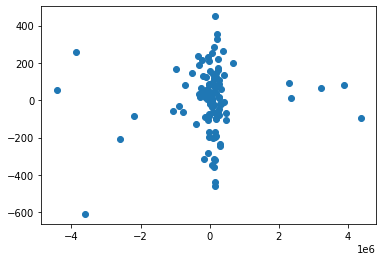

In [ ]:
# 산점도 확인
plt.plot(x, y, 'o')
plt.show()

저 올곧은 기개를 보라...!<br>
결과가 뻔하니 상관분석은 그냥 넘어간다.

<h1>3. 코로나 확진자수 예측</h1>

...지금까지 한게 아쉬우니 그냥 한번 해봤다.

<h2>ARIMA 모델</h2>

In [ ]:
# 서울시 일일 신규 확진자수 데이터
confirmed_data = pd.read_csv("/content/drive/MyDrive/data/MLR/서울시_신규확진자.csv", encoding='euc-kr')
# '기준일' col의 data type을 datetime로 바꿔줌.
confirmed_data = confirmed_data.astype({'기준일': 'datetime64'})
confirmed_data

,기준일,신규확진자
0,2020-01-20,0
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
666,2021-11-16,846
667,2021-11-17,1436
668,2021-11-18,1429
669,2021-11-19,1401


In [ ]:
# 비교해 볼 데이터 기간 조절(이번엔 델타 변이 유행시기 즈음 부터 해보자.)
confirmed_data = confirmed_data[confirmed_data['기준일']>'2021-07-13']

In [ ]:
# 시계열 데이터 생성
timeSeries = confirmed_data.loc[:, ["기준일", "신규확진자"]]
timeSeries.index = timeSeries.기준일
confirmed_ts = timeSeries.drop("기준일", axis=1)

<Figure size 432x288 with 0 Axes>

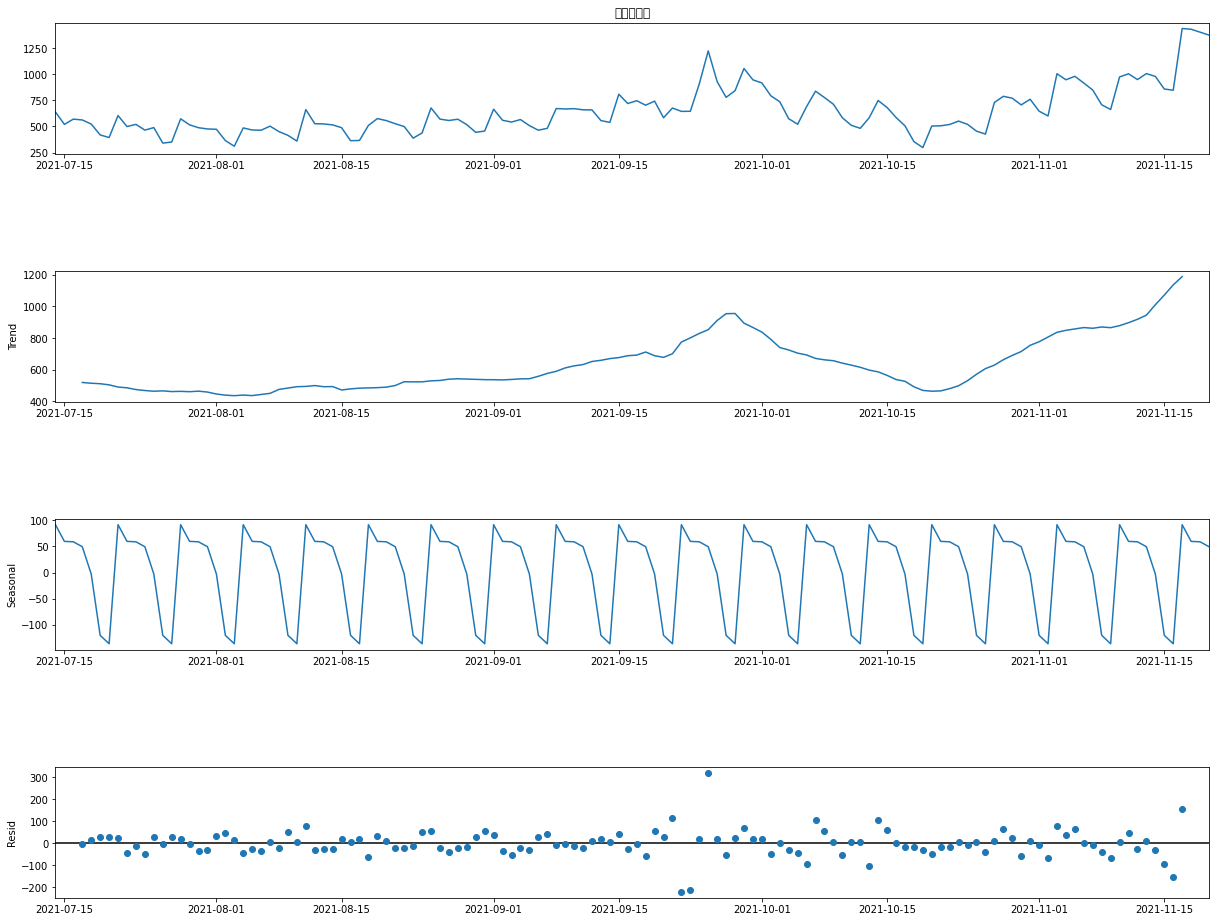

In [ ]:
# model='additive' : 합분해 | period=7 : 계절주기를 7(일주일로) 보통 일간 데이터는 7부터 사용해 확인.
result2 = seasonal_decompose(confirmed_ts['신규확진자'], model='additive', period=7)

fig = plt.figure()
fig = result2.plot()
fig.set_size_inches(20, 15)

In [ ]:
stepwise_fit = auto_arima(confirmed_ts, trace=True, suppress_warnings=True, max_p=7, max_q=7, max_d=7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1619.171, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1620.778, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1620.169, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1617.432, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1610.245, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1604.674, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1612.046, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1606.427, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1606.381, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1610.472, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1604.224, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1609.704, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1

In [ ]:
# 훈련세트와 검증세트를 나눈다. 시계열 데이터이므로 연속된 세트를 이용한다.
print(confirmed_ts.shape)
train = confirmed_ts.iloc[:-7]
test = confirmed_ts.iloc[-7:]
print(train.shape, test.shape)

(130, 1)
(123, 1) (7, 1)


In [ ]:
model = ARIMA(train['신규확진자'], order = (4,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  신규확진자   No. Observations:                  123
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -727.370
Date:                Sat, 27 Nov 2021   AIC                           1468.740
Time:                        11:29:40   BIC                           1488.368
Sample:                    07-14-2021   HQIC                          1476.712
                         - 11-13-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8541      0.126      6.762      0.000       0.607       1.102
ar.L2         -0.8815      0.220     -4.010      0.000      -1.312      -0.451
ar.L3          0.0834      0.232      0.360      0.719      -0.370       0.537
ar.L4         -0.3762      0.160     -2.354      0.019      -0.689      -0.063
ma.L1         -1.2892      0.121    -10.679      0.000      -1.526      -1.053
ma.L2          0.9605      0.130      7.403      0.000       0.706       1.215
sigma2      1.093e+04   1573.782      6.948      0.000    7849.874     1.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               110.28
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             1.28
Prob(H) (two-sided):                  0.22   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

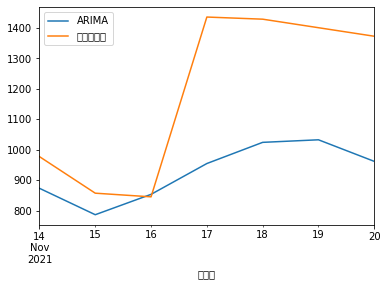

In [ ]:
start = len(train)
end = len(confirmed_ts) - 1
pred = model_fit.predict(start=start, end=end, typ='levels').rename("ARIMA")
pred.plot(legend=True)
test['신규확진자'].plot(legend=True)

<h1>드리프트 ~노선별 영향력 비교~</h1>

뭔가 잘못됐다... 지하철 이용자 전체에 대한 분석은 실패했지만, 노선별로 영향력이 얼마나 다른지는 알아봐도 되지않을까?

In [ ]:
# 지하철 이용자 데이터
metro_df = pd.read_csv('/content/drive/MyDrive/data/MLR/post_corona.csv', encoding='euc-kr')
metro_df = metro_df.astype({'기준일': 'datetime64'})
metro_df

,기준일,노선명,역명,승차총승객수
0,2020-01-01,1호선,종각,20427
1,2020-01-01,1호선,시청,12126
2,2020-01-01,우이신설선,신설동,892
3,2020-01-01,우이신설선,보문,917
4,2020-01-01,우이신설선,성신여대입구(돈암),2010
...,...,...,...,...
399560,2021-10-31,3호선,원흥,5341
399561,2021-10-31,3호선,삼송,11019
399562,2021-10-31,1호선,청량리(서울시립대입구),13011
399563,2021-10-31,1호선,제기동,9959


In [ ]:
# 존재하는 노선 확인
metro_df['노선명'].unique()

array(['1호선', '우이신설선', '9호선', '공항철도', '8호선', '7호선', '6호선', '5호선', '경강선',
       '수인분당선', '경춘선', '경의중앙선', '3호선', '4호선', '2호선'], dtype=object)

In [ ]:
# 각 날짜별 노선의 승차인원을 집계
metro_df = metro_df.groupby(by=['기준일', '노선명'], as_index=False).sum()
metro_df

,기준일,노선명,승차총승객수
0,2020-01-01,1호선,711713
1,2020-01-01,2호선,698987
2,2020-01-01,3호선,298351
3,2020-01-01,4호선,386297
4,2020-01-01,5호선,257295
...,...,...,...
10045,2021-10-31,경의중앙선,121582
10046,2021-10-31,경춘선,33434
10047,2021-10-31,공항철도,64001
10048,2021-10-31,수인분당선,218857


In [ ]:
# 각 노선별로 dataframe을 나눔
line_1 = metro_df[metro_df['노선명']=='1호선']
line_2 = metro_df[metro_df['노선명']=='2호선']
line_3 = metro_df[metro_df['노선명']=='3호선']
line_4 = metro_df[metro_df['노선명']=='4호선']
line_5 = metro_df[metro_df['노선명']=='5호선']
line_6 = metro_df[metro_df['노선명']=='6호선']
line_7 = metro_df[metro_df['노선명']=='7호선']
line_8 = metro_df[metro_df['노선명']=='8호선']
line_9 = metro_df[metro_df['노선명']=='9호선']
line_ui = metro_df[metro_df['노선명']=='우이신설선']
line_air = metro_df[metro_df['노선명']=='공항철도']
line_gg = metro_df[metro_df['노선명']=='경강선']
line_sb = metro_df[metro_df['노선명']=='수인분당선']
line_kc = metro_df[metro_df['노선명']=='경춘선']
line_kj = metro_df[metro_df['노선명']=='경의중앙선']

In [ ]:
# 나눈 dataframe 을 리스트에 저장(다음에 써먹기 위함)
line_list = [line_1, line_2, line_3, line_4, line_5, line_6, line_7, line_8, line_9, line_air, line_gg, line_kc, line_kj, line_sb, line_ui]

In [ ]:
# 설날, 추석에 대한 데이터를 수정(명절은 출퇴근 인구가 서울밖으로 이동했다고 가정 : 유동인구는 변함없다)
for line in line_list:
    # 2020년 설날
    line.loc[line["기준일"]=="2020-01-24", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-01-17", "2020-01-31"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2020-01-25", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-01-18", "2020-02-01"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2020-01-26", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-01-19", "2020-02-02"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2020-01-27", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-01-20", "2020-02-03"])].승차총승객수.mean())
    # 2020년 추석
    line.loc[line["기준일"]=="2020-09-30", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-09-23", "2020-10-07"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2020-10-01", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-09-24", "2020-10-08"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2020-10-02", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-09-25", "2020-10-09"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2020-10-03", ["승차총승객수"]] = int(line[line["기준일"].isin(["2020-09-26", "2020-10-10"])].승차총승객수.mean())
    # 2021년 설날
    line.loc[line["기준일"]=="2021-02-11", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-02-04", "2021-02-18"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2021-02-12", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-02-05", "2021-02-19"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2021-02-13", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-02-06", "2021-02-20"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2021-02-14", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-02-07", "2021-02-21"])].승차총승객수.mean())
    # 2021년 추석
    line.loc[line["기준일"]=="2021-09-19", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-09-12", "2021-09-26"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2021-09-20", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-09-13", "2021-09-27"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2021-09-21", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-09-14", "2021-09-28"])].승차총승객수.mean())
    line.loc[line["기준일"]=="2021-09-22", ["승차총승객수"]] = int(line[line["기준일"].isin(["2021-09-15", "2021-09-29"])].승차총승객수.mean())
    # 기간 조절(왜인지 안됨)
    line = line[line['기준일']>'2021-06-27']

In [ ]:
# 위의 for문으로 기간 조절이 안되서 따로 나눠줌
line_1 = line_1[line_1['기준일']>'2021-06-27']
line_2 = line_2[line_2['기준일']>'2021-06-27']
line_3 = line_3[line_3['기준일']>'2021-06-27']
line_4 = line_4[line_4['기준일']>'2021-06-27']
line_5 = line_5[line_5['기준일']>'2021-06-27']
line_6 = line_6[line_6['기준일']>'2021-06-27']
line_7 = line_7[line_7['기준일']>'2021-06-27']
line_8 = line_8[line_8['기준일']>'2021-06-27']
line_9 = line_9[line_9['기준일']>'2021-06-27']
line_ui = line_ui[line_ui['기준일']>'2021-06-27']
line_air = line_air[line_air['기준일']>'2021-06-27']
line_gg = line_gg[line_gg['기준일']>'2021-06-27']
line_sb = line_sb[line_sb['기준일']>'2021-06-27']
line_kc = line_kc[line_kc['기준일']>'2021-06-27']
line_kj = line_kj[line_kj['기준일']>'2021-06-27']

In [ ]:
# 그 나눠준걸 또 따로 저장 안하면 안되서 저장해줌(원인 몰라서 이슈 남겼음)
line_list = [line_1, line_2, line_3, line_4, line_5, line_6, line_7, line_8, line_9, line_air, line_gg, line_kc, line_kj, line_sb, line_ui]

In [ ]:
# 입력받은 dataframe의 성분을 분해하여 residue를 추출하는 함수
# 주석처리된 코드는 일주일동안(2일~8일전)의 이용자 수로 분석할 때 사용했었음(결과는 망함)
def pearson_residue(dataframe):
#    dataframe['승차인원'] = dataframe['승차총승객수']
#    for i in range(1, 7):
#        dataframe['승차인원'] = dataframe['승차인원'] + dataframe['승차총승객수'].shift(i)
#    dataframe = dataframe.dropna()

#    timeseries = dataframe.loc[:, ["기준일", "승차인원"]]
    timeseries = dataframe.loc[:, ["기준일", "승차총승객수"]]
    timeseries.index = timeseries.기준일
    line_ts = timeseries.drop("기준일", axis=1)
    
#    decompose = seasonal_decompose(line_ts['승차인원'], model='additive', period=7)
    decompose = seasonal_decompose(line_ts['승차총승객수'], model='additive', period=7)
    residue = decompose.resid.dropna()
    print(f'ADF = {adfuller(residue)[1]}, KPSS = {kpss(residue)[1]}')

    return residue

In [ ]:
# 서울시 일일 신규 확진자수 데이터
confirmed_data = pd.read_csv("/content/drive/MyDrive/data/MLR/서울시_신규확진자.csv", encoding='euc-kr')
# '기준일' col의 data type을 datetime로 바꿔줌.
confirmed_data = confirmed_data.astype({'기준일': 'datetime64'})
confirmed_data

,기준일,신규확진자
0,2020-01-20,0
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
666,2021-11-16,846
667,2021-11-17,1436
668,2021-11-18,1429
669,2021-11-19,1401


In [ ]:
# 확진자수의 양상(매주 월화의 수가 적음)을 통해 지하철 이용 2일 혹은 9일 후 정도가 판단하기 좋을 것이라 생각했다.
# 이번엔 2일 후를 기준으로 상관관계를 확인해 보겠다.
# 비교해 볼 데이터 기간 조절(이번엔 델타 변이 유행시기 즈음 부터 해보자.)
confirmed_data = confirmed_data[confirmed_data['기준일']>'2021-07-05']
# 지하철 이용자 수 데이터와 길이를 맞춰줌
confirmed_data = confirmed_data[confirmed_data['기준일']<'2021-11-03']

In [ ]:
# 시계열 데이터 생성
timeSeries = confirmed_data.loc[:, ["기준일", "신규확진자"]]
timeSeries.index = timeSeries.기준일
confirmed_ts = timeSeries.drop("기준일", axis=1)

In [ ]:
# 성분 분해
confirmed_decompose = seasonal_decompose(confirmed_ts['신규확진자'], model='additive', period=7)
confirmed_residue = confirmed_decompose.resid.dropna()

In [ ]:
# ADF검정을 통해 정상성을 확인해봄
# 귀무가설 : stationary 하지 않음
result = adfuller(confirmed_residue)
print(result[1])

1.1020453953224634e-11


In [ ]:
# KPSS검정을 통해 정상성을 확인해봄.
# 귀무가설 : stationary 함
result = kpss(confirmed_residue)
print(result[1])

0.1


In [ ]:
y = confirmed_residue.to_numpy()
line_name_list = ['1호선', '2호선', '3호선', '4호선', '5호선', '6호선', '7호선', '8호선', '9호선', '공항철도', '경강선', '경춘선', '경의중앙선', '수인분당선', '우이신설선']

In [ ]:
# residue 비교(2일차이)
i = 0
for line in line_list:
    print(line_name_list[i], end=' : ')
    temp_ts = pearson_residue(line)
#    x = temp_ts.to_numpy()
    x = temp_ts[6:].to_numpy()
#    print(len(x), len(y))
    print(f'pearson : {stats.pearsonr(x, y)[0]}, p-value : {stats.pearsonr(x, y)[1]}\n')
    i += 1

1호선 : ADF = 1.0907174626597345e-08, KPSS = 0.1
pearson : 0.1910197743897584, p-value : 0.0417661432034135

2호선 : ADF = 1.6114399935352557e-09, KPSS = 0.1
pearson : 0.16477641352543254, p-value : 0.07978448438750074

3호선 : ADF = 4.394146834956928e-09, KPSS = 0.1
pearson : 0.18387817341428936, p-value : 0.05018574773283321

4호선 : ADF = 4.878998217173758e-09, KPSS = 0.1
pearson : 0.17395261827357678, p-value : 0.06417308674399878

5호선 : ADF = 2.353490552221776e-09, KPSS = 0.1
pearson : 0.19335315591278057, p-value : 0.0392850505969982

6호선 : ADF = 1.0532242290785961e-09, KPSS = 0.1
pearson : 0.15194835576682095, p-value : 0.10655546237746774

7호선 : ADF = 1.250552355001406e-09, KPSS = 0.1
pearson : 0.21970624601159397, p-value : 0.018836891050594603

8호선 : ADF = 1.5878253317753904e-10, KPSS = 0.1
pearson : 0.16925145142735526, p-value : 0.07182801744041171

9호선 : ADF = 6.911009111287722e-10, KPSS = 0.1
pearson : 0.1798398647176321, p-value : 0.05553791615298541

공항철도 : ADF = 1.710118702645

3일차 ~ 8일차의 상관계수는 음수가 나왔다...(대체 why?)

In [ ]:
# residue 비교(9일차)
y1 = y[1:]
i = 0
for line in line_list:
    print(line_name_list[i], end=' : ')
    temp_ts = pearson_residue(line)
#    x = temp_ts.to_numpy()
    x = temp_ts[:-7].to_numpy()
    # print(len(x), len(y))
    print(f'pearson : {stats.pearsonr(x, y1)[0]}, p-value : {stats.pearsonr(x, y1)[1]}\n')
    i += 1

1호선 : ADF = 1.0907174626597345e-08, KPSS = 0.1
pearson : 0.062102263736854166, p-value : 0.5134680011577359

2호선 : ADF = 1.6114399935352557e-09, KPSS = 0.1
pearson : 0.07356985884748567, p-value : 0.4386865127937396

3호선 : ADF = 4.394146834956928e-09, KPSS = 0.1
pearson : 0.07202232512859272, p-value : 0.4484027761210324

4호선 : ADF = 4.878998217173758e-09, KPSS = 0.1
pearson : 0.06287207475048286, p-value : 0.5082511710589341

5호선 : ADF = 2.353490552221776e-09, KPSS = 0.1
pearson : 0.06952717958836362, p-value : 0.4643195798329579

6호선 : ADF = 1.0532242290785961e-09, KPSS = 0.1
pearson : 0.06569815180930853, p-value : 0.48933723931012324

7호선 : ADF = 1.250552355001406e-09, KPSS = 0.1
pearson : 0.06944071310943488, p-value : 0.46487666272866146

8호선 : ADF = 1.5878253317753904e-10, KPSS = 0.1
pearson : 0.0656436913023669, p-value : 0.48969815649061066

9호선 : ADF = 6.911009111287722e-10, KPSS = 0.1
pearson : 0.08026347674062848, p-value : 0.39806033381899714

공항철도 : ADF = 1.71011870264526